CELL 1: Installation and Imports

In [ ]:
# Install required libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q
!pip install kaggle matplotlib seaborn scikit-learn pandas numpy pillow tqdm -q
!pip install torchmetrics -q

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Set device to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Check GPU details if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.2 MB/s eta 0:00:00
Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB


CELL 2: Mount Google Drive and Setup Kaggle API

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

print("Google Drive mounted successfully!")

Mounted at /content/drive
Google Drive mounted successfully!


CELL 3: Download Dataset from Kaggle

In [ ]:
# Setup Kaggle API
!mkdir -p ~/.kaggle

# Copy kaggle.json from Drive (upload it to your Drive first)
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured!")

Kaggle API configured!


In [ ]:
# Download the lightweight malaria dataset
!kaggle datasets download -d shahriar26s/malaria-detection -p /content/malaria_data --quiet

print("Dataset download completed!")

# Extract the dataset
extract_path = '/content/malaria_data/'
for file in os.listdir(extract_path):
    if file.endswith('.zip'):
        zip_path = os.path.join(extract_path, file)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Extracted {file}")

print("Dataset extracted successfully!")


Dataset URL: https://www.kaggle.com/datasets/shahriar26s/malaria-detection
License(s): apache-2.0
Dataset download completed!
Extracted malaria-detection.zip
Dataset extracted successfully!


CELL 4: Explore Dataset Structure

In [ ]:
# Find the data directory
data_root = '/content/malaria_data'

# List all directories to find the dataset folder
for root, dirs, files in os.walk(data_root):
    if 'train' in dirs or 'Train' in dirs:
        print(f"Found dataset root: {root}")
        data_root = root
        break

print(f"Dataset root: {data_root}")

# Check structure
print("\nDirectory structure:")
for item in os.listdir(data_root):
    item_path = os.path.join(data_root, item)
    if os.path.isdir(item_path):
        num_files = len(os.listdir(item_path))
        print(f"  {item}: {num_files} items")


Found dataset root: /content/malaria_data/Malaria Dataset
Dataset root: /content/malaria_data/Malaria Dataset

Directory structure:
  train: 2 items
  test: 2 items
  valid: 2 items


In [ ]:
# Define paths based on dataset structure
# The dataset has: train, valid, test folders

train_dir = os.path.join(data_root, 'train')
valid_dir = os.path.join(data_root, 'valid')
test_dir = os.path.join(data_root, 'test')

print(f"\nTrain directory: {train_dir}")
print(f"Valid directory: {valid_dir}")
print(f"Test directory: {test_dir}")

# Count images in each directory
def count_images(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                count += 1
    return count

train_count = count_images(train_dir)
valid_count = count_images(valid_dir)
test_count = count_images(test_dir)

print(f"\nTotal images:")
print(f"  Training: {train_count}")
print(f"  Validation: {valid_count}")
print(f"  Test: {test_count}")
print(f"  Total: {train_count + valid_count + test_count}")



Train directory: /content/malaria_data/Malaria Dataset/train
Valid directory: /content/malaria_data/Malaria Dataset/valid
Test directory: /content/malaria_data/Malaria Dataset/test

Total images:
  Training: 13152
  Validation: 1253
  Test: 626
  Total: 15031


CELL 5: Visualize Sample Images from Dataset

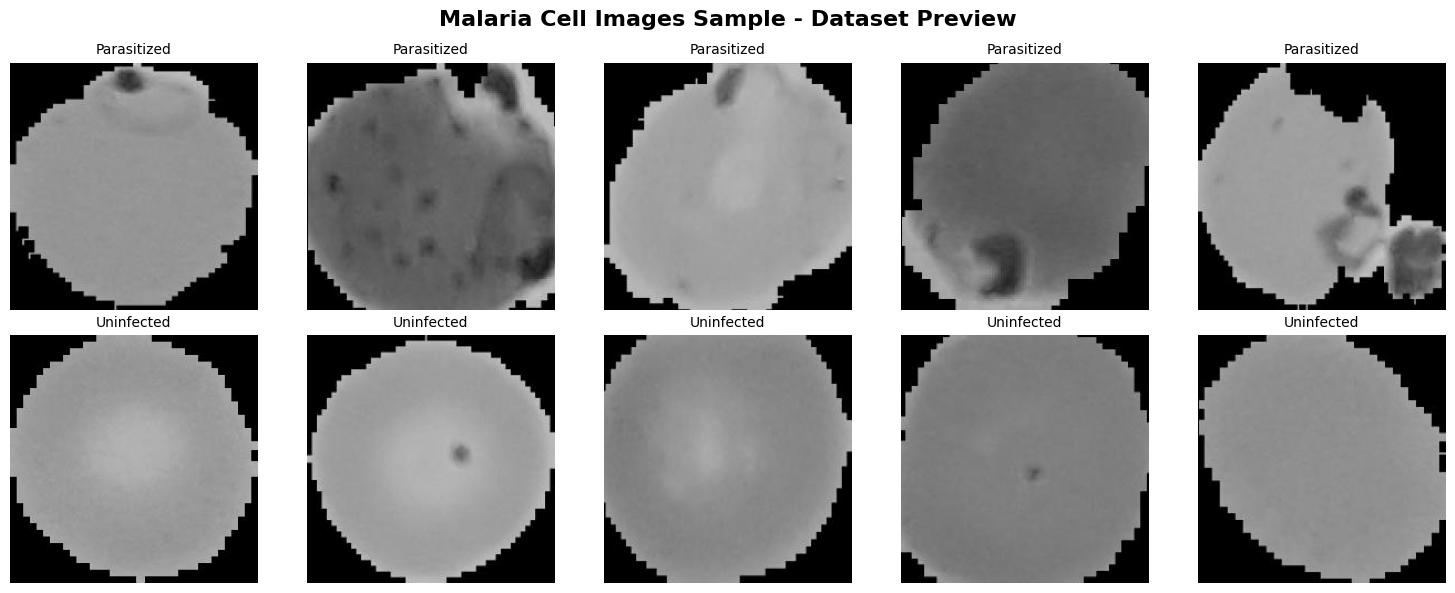

Sample images displayed!


In [ ]:
# Define class names
class_names = ['Parasitized', 'Uninfected']

# Visualize samples from train directory
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Malaria Cell Images Sample - Dataset Preview', fontsize=16, fontweight='bold')

# Get sample images from each class
for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)

    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for idx in range(min(5, len(images))):
            img_path = os.path.join(class_path, images[idx])
            img = Image.open(img_path)

            axes[class_idx, idx].imshow(img)
            axes[class_idx, idx].set_title(class_name, fontsize=10)
            axes[class_idx, idx].axis('off')

plt.tight_layout()
plt.show()

print("Sample images displayed!")


CELL 6: Create Custom Dataset Class

In [ ]:
class MalariaDataset(Dataset):
    """
    Custom Dataset class for loading Malaria cell images.
    Supports both directory-based loading and pre-split train/val/test structure.

    Args:
        root_dir (str): Root directory containing class folders
        class_names (list): List of class folder names
        transform (transforms.Compose): Image transformations to apply
    """
    def __init__(self, root_dir, class_names, transform=None):
        self.root_dir = root_dir
        self.class_names = class_names
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Collect all image paths and labels
        for class_idx, class_name in enumerate(class_names):
            class_dir = os.path.join(root_dir, class_name)

            if not os.path.exists(class_dir):
                print(f"Warning: Class directory not found: {class_dir}")
                continue

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)

        print(f"Loaded {len(self.image_paths)} images from {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # If image is corrupted, return a random valid image
            idx = np.random.randint(0, len(self.image_paths))
            image = Image.open(self.image_paths[idx]).convert('RGB')

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


CELL 7: Define Data Transformations (Optimized for Quick Training)

In [ ]:
# Training transformations with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Already resized in dataset, but ensure consistency
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(degrees=10),  # Random rotation (reduced for speed)
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),  # Color jittering
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Small random translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Test transformations - no augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print("Data transformations defined successfully!")


Data transformations defined successfully!


CELL 8: Create Data Loaders

In [ ]:
# Create dataset instances from pre-split directories
train_dataset = MalariaDataset(
    root_dir=train_dir,
    class_names=class_names,
    transform=train_transform
)

val_dataset = MalariaDataset(
    root_dir=valid_dir,
    class_names=class_names,
    transform=test_transform
)

test_dataset = MalariaDataset(
    root_dir=test_dir,
    class_names=class_names,
    transform=test_transform
)

# Create data loaders
# Reduced batch size for free GPU memory constraints
batch_size = 16  # Optimized for free Colab GPU

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nDataLoader Information:")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_dataloader)}")
print(f"  Validation batches: {len(val_dataloader)}")
print(f"  Test batches: {len(test_dataloader)}")
print(f"\n  Train dataset size: {len(train_dataset)}")
print(f"  Validation dataset size: {len(val_dataset)}")
print(f"  Test dataset size: {len(test_dataset)}")


Loaded 13152 images from /content/malaria_data/Malaria Dataset/train
Loaded 1253 images from /content/malaria_data/Malaria Dataset/valid
Loaded 626 images from /content/malaria_data/Malaria Dataset/test

DataLoader Information:
  Batch size: 16
  Train batches: 822
  Validation batches: 79
  Test batches: 40

  Train dataset size: 13152
  Validation dataset size: 1253
  Test dataset size: 626


CELL 9: Test DataLoader (Verify Everything Works)

In [ ]:
# Test loading a batch
try:
    sample_batch, sample_labels = next(iter(train_dataloader))
    print(f"✓ DataLoader working correctly!")
    print(f"  Batch shape: {sample_batch.shape}")
    print(f"  Labels shape: {sample_labels.shape}")
    print(f"  Batch dtype: {sample_batch.dtype}")
except Exception as e:
    print(f"✗ Error in DataLoader: {e}")


✓ DataLoader working correctly!
  Batch shape: torch.Size([16, 3, 224, 224])
  Labels shape: torch.Size([16])
  Batch dtype: torch.float32


CELL 10: Accuracy Function

In [ ]:
def accuracy_fn(y_true, y_pred):
    """
    Calculate accuracy between predictions and true labels.

    Args:
        y_true: Tensor of true labels
        y_pred: Tensor of predicted labels

    Returns:
        Accuracy as percentage
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc


CELL 11: Training Step Function

In [ ]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    """
    Perform one training epoch.

    Args:
        model: PyTorch model to train
        data_loader: Training data loader
        loss_fn: Loss function
        optimizer: Optimizer
        accuracy_fn: Accuracy function
        device: Device (CPU/GPU)

    Returns:
        train_loss: Average training loss
        train_acc: Average training accuracy
    """
    train_loss, train_acc = 0, 0
    model.train()  # Set model to training mode

    for X, y in tqdm(data_loader, desc="Training", leave=False):
        # Move data to device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_logits = model(X)

        # Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping for stability
        optimizer.step()

        # Calculate accuracy
        y_pred = y_logits.argmax(dim=1)
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred)

    # Average metrics
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc


CELL 12: Validation Step Function

In [ ]:
def val_step(model, data_loader, loss_fn, accuracy_fn, device):
    """
    Perform validation/testing evaluation.

    Args:
        model: PyTorch model to evaluate
        data_loader: Validation/test data loader
        loss_fn: Loss function
        accuracy_fn: Accuracy function
        device: Device (CPU/GPU)

    Returns:
        val_loss: Average validation loss
        val_acc: Average validation accuracy
    """
    val_loss, val_acc = 0, 0
    model.eval()  # Set model to evaluation mode

    with torch.inference_mode():  # No gradient computation
        for X, y in tqdm(data_loader, desc="Validating", leave=False):
            # Move data to device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_logits = model(X)

            # Calculate loss
            loss = loss_fn(y_logits, y)
            val_loss += loss.item()

            # Calculate accuracy
            y_pred = y_logits.argmax(dim=1)
            val_acc += accuracy_fn(y_true=y, y_pred=y_pred)

    # Average metrics
    val_loss /= len(data_loader)
    val_acc /= len(data_loader)

    return val_loss, val_acc


CELL 13: Complete Training Loop

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer,
                accuracy_fn, device, epochs=15, model_name="Model"):
    """
    Complete training loop for a model.

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        loss_fn: Loss function
        optimizer: Optimizer
        accuracy_fn: Accuracy function
        device: Device (CPU/GPU)
        epochs: Number of epochs (reduced to 5 for speed)
        model_name: Name of the model

    Returns:
        results: Dictionary with training history
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    best_val_acc = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs} - {model_name}")
        print("-" * 60)

        # Training step
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device
        )

        # Validation step
        val_loss, val_acc = val_step(
            model=model,
            data_loader=val_loader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
        )

        # Update results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Print metrics
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"✓ Best validation accuracy updated: {best_val_acc:.2f}%")

    print(f"\n{model_name} training completed!")

    return results


CELL 14: Plot Loss and Accuracy Curves

In [ ]:
def plot_loss_curves(results, model_name="Model"):
    """
    Plot training and validation loss and accuracy curves.

    Args:
        results: Dictionary with training history
        model_name: Name of the model for title
    """
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]
    epochs = range(1, len(train_loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss
    ax1.plot(epochs, train_loss, 'b-', label="Train Loss", marker='o', linewidth=2)
    ax1.plot(epochs, val_loss, 'r-', label="Val Loss", marker='s', linewidth=2)
    ax1.set_xlabel("Epochs", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.set_title(f"{model_name} - Loss Curves", fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(epochs, train_acc, 'b-', label="Train Accuracy", marker='o', linewidth=2)
    ax2.plot(epochs, val_acc, 'r-', label="Val Accuracy", marker='s', linewidth=2)
    ax2.set_xlabel("Epochs", fontsize=12)
    ax2.set_ylabel("Accuracy (%)", fontsize=12)
    ax2.set_title(f"{model_name} - Accuracy Curves", fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


CELL 15: Save and Load Model Functions

In [ ]:
def save_model(model, model_name):
    """
    Save model state dictionary.

    Args:
        model: PyTorch model
        model_name: Name for the model file
    """
    save_path = Path("malaria_models")
    save_path.mkdir(parents=True, exist_ok=True)

    full_path = save_path / f"{model_name}.pth"
    torch.save(model.state_dict(), full_path)
    print(f"✓ Model saved: {full_path}")


def load_model(model, model_name):
    """
    Load model state dictionary.

    Args:
        model: PyTorch model
        model_name: Name of the model file to load
    """
    load_path = Path("malaria_models") / f"{model_name}.pth"
    if load_path.exists():
        model.load_state_dict(torch.load(load_path, map_location=device))
        print(f"✓ Model loaded: {load_path}")
    else:
        print(f"✗ Model file not found: {load_path}")
    return model


CELL 16: Get Predictions Function

In [ ]:
def get_predictions(model, data_loader, device):
    """
    Get model predictions and true labels for evaluation.

    Args:
        model: PyTorch model
        data_loader: Data loader
        device: Device (CPU/GPU)

    Returns:
        predictions: Model predictions
        true_labels: True labels
    """
    model.eval()
    predictions = []
    true_labels = []

    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Getting predictions", leave=False):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            y_pred = y_logits.argmax(dim=1)

            predictions.append(y_pred.cpu().numpy())
            true_labels.append(y.cpu().numpy())

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)

    return predictions, true_labels


CELL 17: MODEL 1 - ResNet50 (Lightweight Version)

MODEL 1: ResNet50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]



Model Parameters: 23,512,130

Training ResNet50...

Epoch 1/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.2663 | Train Acc: 92.08%
Val Loss: 0.1535 | Val Acc: 94.94%
✓ Best validation accuracy updated: 94.94%

Epoch 2/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1857 | Train Acc: 94.18%
Val Loss: 0.1439 | Val Acc: 95.57%
✓ Best validation accuracy updated: 95.57%

Epoch 3/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1775 | Train Acc: 94.48%
Val Loss: 0.1435 | Val Acc: 95.81%
✓ Best validation accuracy updated: 95.81%

Epoch 4/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1671 | Train Acc: 94.84%
Val Loss: 0.1359 | Val Acc: 96.12%
✓ Best validation accuracy updated: 96.12%

Epoch 5/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1613 | Train Acc: 94.93%
Val Loss: 0.1276 | Val Acc: 95.73%

Epoch 6/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1557 | Train Acc: 95.04%
Val Loss: 0.1307 | Val Acc: 95.89%

Epoch 7/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1553 | Train Acc: 95.18%
Val Loss: 0.1436 | Val Acc: 95.97%

Epoch 8/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1521 | Train Acc: 95.14%
Val Loss: 0.1258 | Val Acc: 96.12%

Epoch 9/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1457 | Train Acc: 95.28%
Val Loss: 0.1270 | Val Acc: 95.81%

Epoch 10/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1442 | Train Acc: 95.52%
Val Loss: 0.1268 | Val Acc: 96.20%
✓ Best validation accuracy updated: 96.20%

Epoch 11/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1425 | Train Acc: 95.58%
Val Loss: 0.1295 | Val Acc: 96.04%

Epoch 12/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1393 | Train Acc: 95.42%
Val Loss: 0.1181 | Val Acc: 95.97%

Epoch 13/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1374 | Train Acc: 95.64%
Val Loss: 0.1145 | Val Acc: 96.12%

Epoch 14/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1334 | Train Acc: 95.73%
Val Loss: 0.1341 | Val Acc: 95.57%

Epoch 15/15 - ResNet50
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1350 | Train Acc: 95.66%
Val Loss: 0.1382 | Val Acc: 95.97%

ResNet50 training completed!


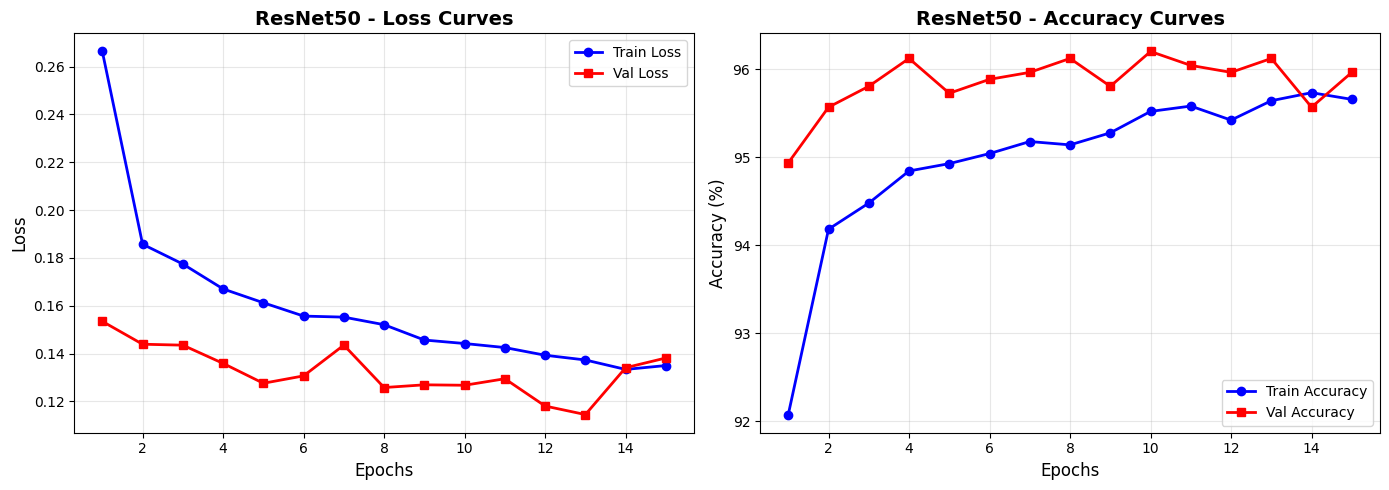

✓ Model saved: malaria_models/resnet50.pth


In [ ]:
# ========== MODEL 1: ResNet50 ==========
print("=" * 70)
print("MODEL 1: ResNet50")
print("=" * 70)

# Load and configure model
resnet50_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_classes = 2
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, num_classes)
resnet50_model.to(device)

# ✓ DECLARE FRESH LOSS FUNCTION & OPTIMIZER FOR THIS MODEL
loss_fn_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet50_model.parameters(), lr=0.001)

print(f"\nModel Parameters: {sum(p.numel() for p in resnet50_model.parameters()):,}")

# Train the model
print("\n" + "=" * 70)
print("Training ResNet50...")
print("=" * 70)
torch.manual_seed(42)

results_resnet50 = train_model(
    model=resnet50_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    loss_fn=loss_fn_resnet,           # ✓ Use ResNet-specific loss
    optimizer=optimizer_resnet,        # ✓ Use ResNet-specific optimizer
    accuracy_fn=accuracy_fn,
    device=device,
    epochs=15,
    model_name="ResNet50"
)

plot_loss_curves(results_resnet50, "ResNet50")
save_model(resnet50_model, "resnet50")


CELL 18: MODEL 2 - EfficientNet-B0 (Lightweight & Fast)

MODEL 3: EfficientNet-B0
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 103MB/s]



Model Parameters: 4,010,110

Training EfficientNet-B0...

Epoch 1/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.2029 | Train Acc: 93.73%
Val Loss: 0.1227 | Val Acc: 95.89%
✓ Best validation accuracy updated: 95.89%

Epoch 2/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1513 | Train Acc: 95.30%
Val Loss: 0.1340 | Val Acc: 95.25%

Epoch 3/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1394 | Train Acc: 95.56%
Val Loss: 0.1287 | Val Acc: 95.33%

Epoch 4/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1315 | Train Acc: 95.62%
Val Loss: 0.1045 | Val Acc: 95.89%

Epoch 5/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1196 | Train Acc: 95.98%
Val Loss: 0.1094 | Val Acc: 96.20%
✓ Best validation accuracy updated: 96.20%

Epoch 6/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1096 | Train Acc: 96.29%
Val Loss: 0.0834 | Val Acc: 97.55%
✓ Best validation accuracy updated: 97.55%

Epoch 7/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1074 | Train Acc: 96.27%
Val Loss: 0.0799 | Val Acc: 96.84%

Epoch 8/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1021 | Train Acc: 96.59%
Val Loss: 0.0870 | Val Acc: 96.44%

Epoch 9/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0944 | Train Acc: 96.67%
Val Loss: 0.0752 | Val Acc: 97.39%

Epoch 10/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0923 | Train Acc: 96.81%
Val Loss: 0.0811 | Val Acc: 97.63%
✓ Best validation accuracy updated: 97.63%

Epoch 11/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0897 | Train Acc: 97.08%
Val Loss: 0.0818 | Val Acc: 96.91%

Epoch 12/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0839 | Train Acc: 97.08%
Val Loss: 0.0751 | Val Acc: 96.99%

Epoch 13/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0783 | Train Acc: 97.21%
Val Loss: 0.0887 | Val Acc: 96.68%

Epoch 14/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0796 | Train Acc: 97.34%
Val Loss: 0.1022 | Val Acc: 96.04%

Epoch 15/15 - EfficientNet-B0
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.0789 | Train Acc: 97.33%
Val Loss: 0.0914 | Val Acc: 96.84%

EfficientNet-B0 training completed!


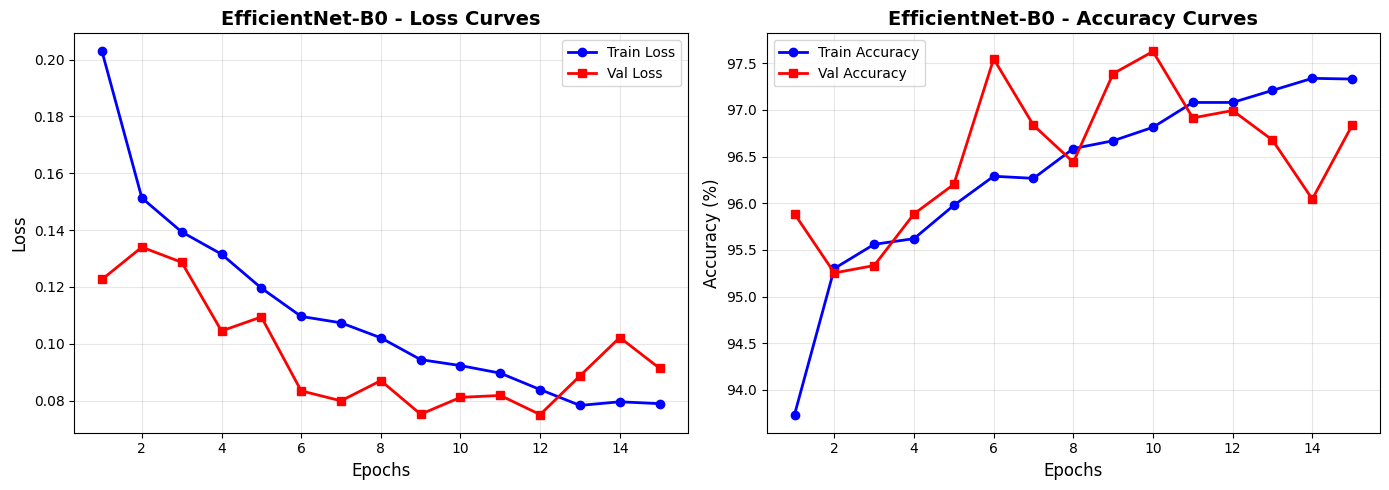

✓ Model saved: malaria_models/efficientnet_b0.pth


In [ ]:
# ========== MODEL 3: EfficientNet-B0 ==========
print("=" * 70)
print("MODEL 3: EfficientNet-B0")
print("=" * 70)

# Load and configure model
efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, num_classes)
)
efficientnet_model.to(device)

# ✓ DECLARE FRESH LOSS FUNCTION & OPTIMIZER FOR THIS MODEL
loss_fn_efficient = nn.CrossEntropyLoss()
optimizer_efficient = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)

print(f"\nModel Parameters: {sum(p.numel() for p in efficientnet_model.parameters()):,}")

# Train the model
print("\n" + "=" * 70)
print("Training EfficientNet-B0...")
print("=" * 70)
torch.manual_seed(42)

results_efficientnet = train_model(
    model=efficientnet_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    loss_fn=loss_fn_efficient,        # ✓ Use EfficientNet-specific loss
    optimizer=optimizer_efficient,     # ✓ Use EfficientNet-specific optimizer
    accuracy_fn=accuracy_fn,
    device=device,
    epochs=15,
    model_name="EfficientNet-B0"
)

plot_loss_curves(results_efficientnet, "EfficientNet-B0")
save_model(efficientnet_model, "efficientnet_b0")


CELL 19: MODEL 3 - MobileNetV2 (Fastest & Most Efficient)

MODEL 4: MobileNetV2
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s] 


Model Parameters: 2,226,434

Training MobileNetV2...

Epoch 1/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.2339 | Train Acc: 93.01%
Val Loss: 0.1348 | Val Acc: 95.33%
✓ Best validation accuracy updated: 95.33%

Epoch 2/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1730 | Train Acc: 94.54%
Val Loss: 0.1328 | Val Acc: 95.73%
✓ Best validation accuracy updated: 95.73%

Epoch 3/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1619 | Train Acc: 94.84%
Val Loss: 0.1907 | Val Acc: 94.86%

Epoch 4/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1566 | Train Acc: 95.12%
Val Loss: 0.1210 | Val Acc: 96.28%
✓ Best validation accuracy updated: 96.28%

Epoch 5/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1467 | Train Acc: 95.40%
Val Loss: 0.1459 | Val Acc: 94.54%

Epoch 6/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1494 | Train Acc: 95.27%
Val Loss: 0.1261 | Val Acc: 96.36%
✓ Best validation accuracy updated: 96.36%

Epoch 7/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1448 | Train Acc: 95.46%
Val Loss: 0.1283 | Val Acc: 95.73%

Epoch 8/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1373 | Train Acc: 95.66%
Val Loss: 0.1104 | Val Acc: 96.28%

Epoch 9/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1347 | Train Acc: 95.51%
Val Loss: 0.1111 | Val Acc: 96.52%
✓ Best validation accuracy updated: 96.52%

Epoch 10/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1339 | Train Acc: 95.64%
Val Loss: 0.1189 | Val Acc: 96.20%

Epoch 11/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1338 | Train Acc: 95.73%
Val Loss: 0.1074 | Val Acc: 96.60%
✓ Best validation accuracy updated: 96.60%

Epoch 12/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1298 | Train Acc: 95.76%
Val Loss: 0.1214 | Val Acc: 95.97%

Epoch 13/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1254 | Train Acc: 95.89%
Val Loss: 0.1021 | Val Acc: 96.36%

Epoch 14/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1234 | Train Acc: 95.89%
Val Loss: 0.1080 | Val Acc: 96.28%

Epoch 15/15 - MobileNetV2
------------------------------------------------------------


Training:   0%|          | 0/822 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Train Loss: 0.1269 | Train Acc: 95.91%
Val Loss: 0.1166 | Val Acc: 96.60%

MobileNetV2 training completed!


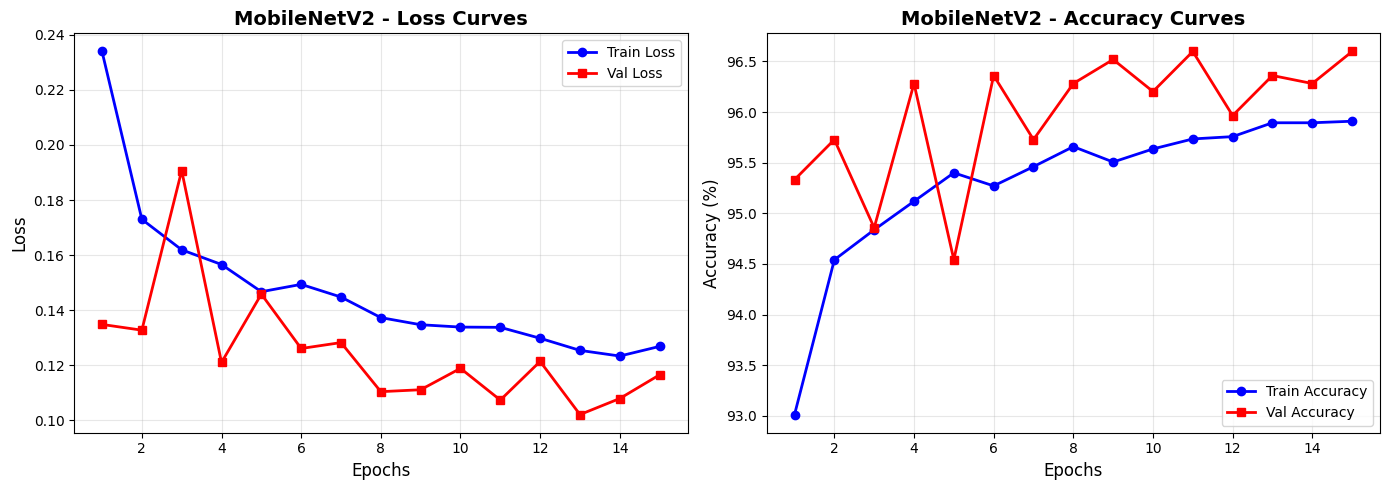

✓ Model saved: malaria_models/mobilenet_v2.pth


In [ ]:
# ========== MODEL 4: MobileNetV2 ==========
print("=" * 70)
print("MODEL 4: MobileNetV2")
print("=" * 70)

# Load and configure model
mobilenet_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobilenet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, num_classes)
)
mobilenet_model.to(device)

# ✓ DECLARE FRESH LOSS FUNCTION & OPTIMIZER FOR THIS MODEL
loss_fn_mobile = nn.CrossEntropyLoss()
optimizer_mobile = torch.optim.Adam(mobilenet_model.parameters(), lr=0.001)

print(f"\nModel Parameters: {sum(p.numel() for p in mobilenet_model.parameters()):,}")

# Train the model
print("\n" + "=" * 70)
print("Training MobileNetV2...")
print("=" * 70)
torch.manual_seed(42)

results_mobilenet = train_model(
    model=mobilenet_model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    loss_fn=loss_fn_mobile,           # ✓ Use MobileNet-specific loss
    optimizer=optimizer_mobile,        # ✓ Use MobileNet-specific optimizer
    accuracy_fn=accuracy_fn,
    device=device,
    epochs=15,
    model_name="MobileNetV2"
)

plot_loss_curves(results_mobilenet, "MobileNetV2")
save_model(mobilenet_model, "mobilenet_v2")


CELL 20: Get Test Predictions for All Models

In [ ]:
print("=" * 70)
print("GETTING TEST PREDICTIONS")
print("=" * 70)

# ResNet50 predictions
print("\nResNet50...")
resnet_preds, test_labels = get_predictions(resnet50_model, test_dataloader, device)

# EfficientNet-B0 predictions
print("EfficientNet-B0...")
efficient_preds, _ = get_predictions(efficientnet_model, test_dataloader, device)

# MobileNetV2 predictions
print("MobileNetV2...")
mobilenet_preds, _ = get_predictions(mobilenet_model, test_dataloader, device)

print("\n✓ Predictions obtained for all models!")
print(f"  Test set size: {len(test_labels)}")


GETTING TEST PREDICTIONS

ResNet50...


Getting predictions:   0%|          | 0/40 [00:00<?, ?it/s]

EfficientNet-B0...


Getting predictions:   0%|          | 0/40 [00:00<?, ?it/s]

MobileNetV2...


Getting predictions:   0%|          | 0/40 [00:00<?, ?it/s]


✓ Predictions obtained for all models!
  Test set size: 626


CELL 21: Calculate Evaluation Metrics for All Models


In [ ]:
# Function to calculate all metrics
def calculate_metrics(y_true, y_pred, model_name):
    """
    Calculate comprehensive evaluation metrics.

    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name of the model

    Returns:
        Dictionary with metrics
    """
    acc = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0) * 100

    print(f"\n{model_name}:")
    print(f"  Accuracy:  {acc:.2f}%")
    print(f"  Precision: {precision:.2f}%")
    print(f"  Recall:    {recall:.2f}%")
    print(f"  F1-Score:  {f1:.2f}%")

    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Calculate metrics for all models
print("=" * 70)
print("MODEL EVALUATION ON TEST SET")
print("=" * 70)

metrics_resnet = calculate_metrics(test_labels, resnet_preds, "ResNet50")
metrics_efficient = calculate_metrics(test_labels, efficient_preds, "EfficientNet-B0")
metrics_mobilenet = calculate_metrics(test_labels, mobilenet_preds, "MobileNetV2")

# Create comparison dataframe
comparison_df = pd.DataFrame([
    metrics_resnet,
    metrics_efficient,
    metrics_mobilenet
])

print("\n" + "=" * 70)
print("COMPARISON TABLE")
print("=" * 70)
print(comparison_df.to_string(index=False))


MODEL EVALUATION ON TEST SET

ResNet50:
  Accuracy:  95.05%
  Precision: 95.05%
  Recall:    95.05%
  F1-Score:  95.05%

EfficientNet-B0:
  Accuracy:  95.05%
  Precision: 95.05%
  Recall:    95.05%
  F1-Score:  95.05%

MobileNetV2:
  Accuracy:  95.69%
  Precision: 95.69%
  Recall:    95.69%
  F1-Score:  95.69%

COMPARISON TABLE
          Model  Accuracy  Precision    Recall  F1-Score
       ResNet50 95.047923  95.052668 95.047923 95.048113
EfficientNet-B0 95.047923  95.051457 95.047923 95.047506
    MobileNetV2 95.686901  95.687543 95.686901 95.686978


CELL 22: Visualize Model Comparison - Bar Chart

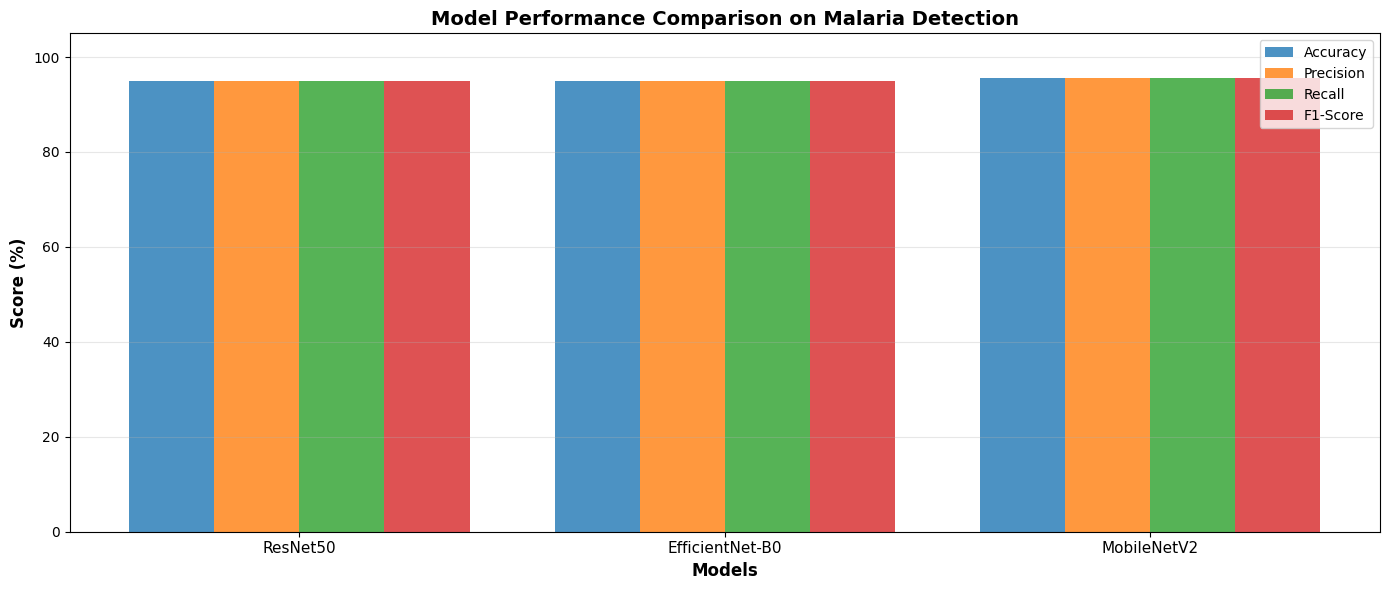

In [ ]:
# Plot comparison metrics
fig, ax = plt.subplots(figsize=(14, 6))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
models_list = comparison_df['Model'].tolist()

x = np.arange(len(models_list))
width = 0.2

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for i, metric in enumerate(metrics_names):
    values = comparison_df[metric].tolist()
    bars = ax.bar(x + i*width, values, width, label=metric, alpha=0.8)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison on Malaria Detection', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models_list, fontsize=11)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()


CELL 23: Confusion Matrices for All Models

CONFUSION MATRICES


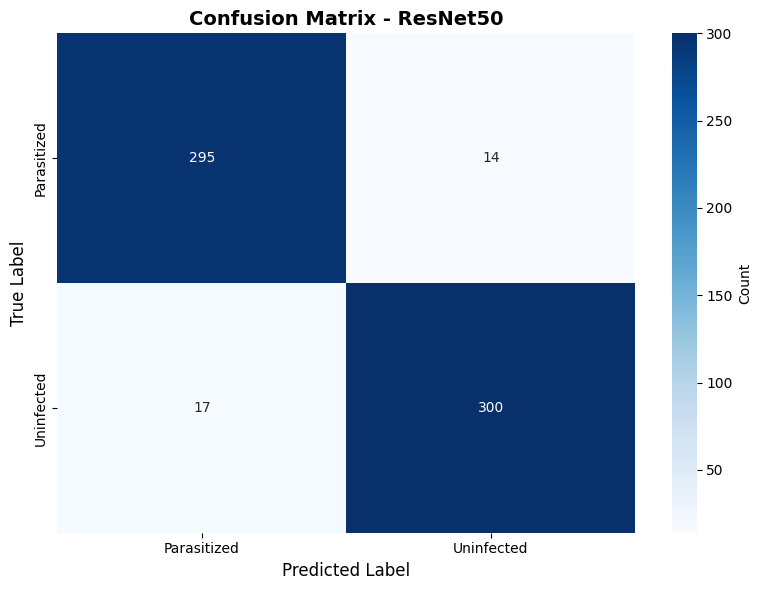

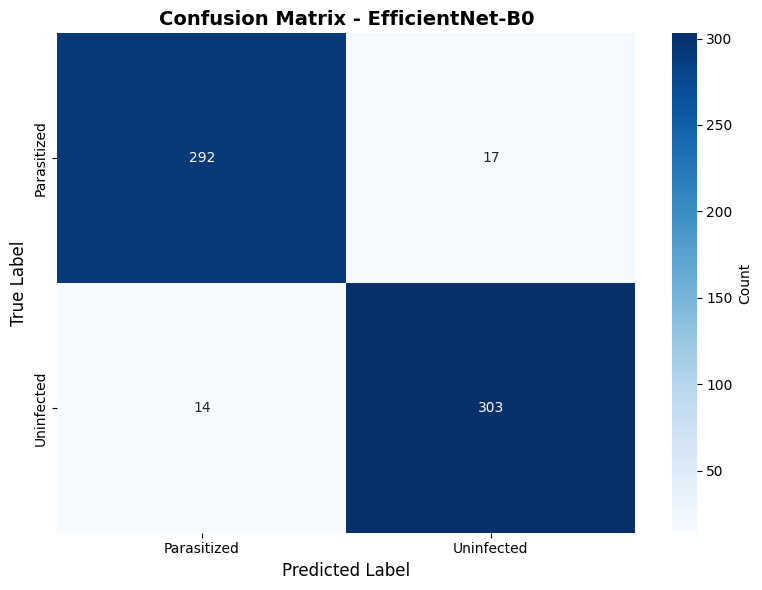

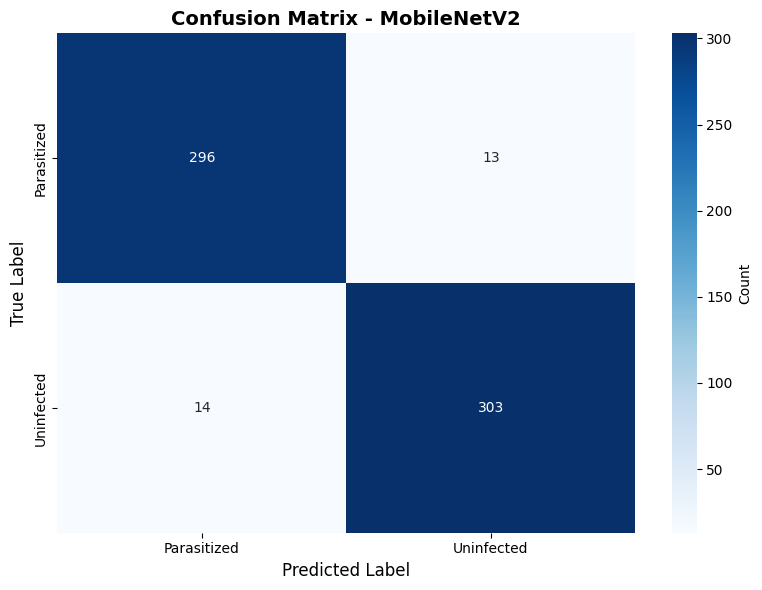

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix_custom(y_true, y_pred, model_name, class_names):
    """
    Plot confusion matrix for a model.

    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Model name for title
        class_names: Class names
    """
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, cbar_kws={'label': 'Count'})
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for all models
print("=" * 70)
print("CONFUSION MATRICES")
print("=" * 70)

plot_confusion_matrix_custom(test_labels, resnet_preds, "ResNet50", class_names)
plot_confusion_matrix_custom(test_labels, efficient_preds, "EfficientNet-B0", class_names)
plot_confusion_matrix_custom(test_labels, mobilenet_preds, "MobileNetV2", class_names)


CELL 24: Model Accuracy Comparison - Horizontal Bar Chart

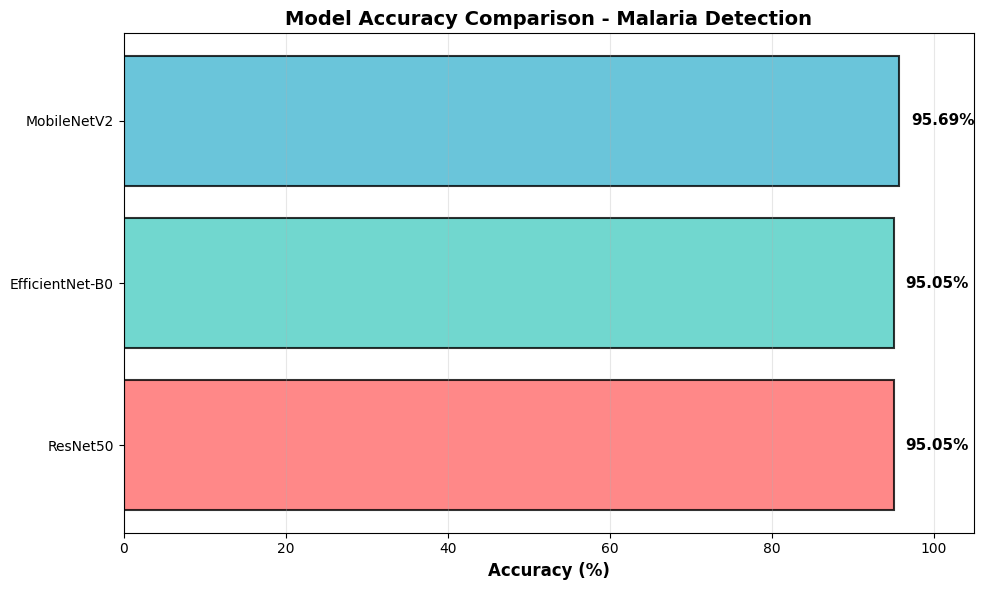

In [ ]:
# Horizontal bar chart for accuracy comparison
fig, ax = plt.subplots(figsize=(10, 6))

models_list = comparison_df['Model'].tolist()
accuracy_list = comparison_df['Accuracy'].tolist()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

bars = ax.barh(models_list, accuracy_list, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy Comparison - Malaria Detection', fontsize=14, fontweight='bold')
ax.set_xlim([0, 105])

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, accuracy_list)):
    ax.text(acc + 1.5, i, f'{acc:.2f}%', va='center', fontweight='bold', fontsize=11)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


CELL 25: Create Comprehensive Results Report

In [ ]:
# Create a comprehensive results CSV
results_report = pd.DataFrame({
    'Model': comparison_df['Model'],
    'Test_Accuracy_%': comparison_df['Accuracy'].round(2),
    'Test_Precision_%': comparison_df['Precision'].round(2),
    'Test_Recall_%': comparison_df['Recall'].round(2),
    'Test_F1_Score_%': comparison_df['F1-Score'].round(2),
    'Val_Accuracy_%': [
        results_resnet50['val_acc'][-1],
        results_efficientnet['val_acc'][-1],
        results_mobilenet['val_acc'][-1]
    ],
    'Train_Accuracy_%': [
        results_resnet50['train_acc'][-1],
        results_efficientnet['train_acc'][-1],
        results_mobilenet['train_acc'][-1]
    ]
})

# Save to CSV
results_report.to_csv('malaria_detection_results.csv', index=False)

print("\n" + "=" * 70)
print("COMPREHENSIVE RESULTS REPORT")
print("=" * 70)
print(results_report.to_string(index=False))
print("\n✓ Results saved to 'malaria_detection_results.csv'")

# Display file size
import os
file_size = os.path.getsize('malaria_detection_results.csv')
print(f"  File size: {file_size} bytes")



COMPREHENSIVE RESULTS REPORT
          Model  Test_Accuracy_%  Test_Precision_%  Test_Recall_%  Test_F1_Score_%  Val_Accuracy_%  Train_Accuracy_%
       ResNet50            95.05             95.05          95.05            95.05       95.965190         95.658455
EfficientNet-B0            95.05             95.05          95.05            95.05       96.835443         97.331204
    MobileNetV2            95.69             95.69          95.69            95.69       96.598101         95.909367

✓ Results saved to 'malaria_detection_results.csv'
  File size: 318 bytes


CELL 26: Best Model Analysis

In [ ]:
# Find best model
best_model_idx = comparison_df['Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Accuracy']

print("=" * 70)
print("BEST MODEL ANALYSIS")
print("=" * 70)
print(f"\nBest Model: {best_model_name}")
print(f"  Accuracy: {best_accuracy:.2f}%")
print(f"  Precision: {comparison_df.loc[best_model_idx, 'Precision']:.2f}%")
print(f"  Recall: {comparison_df.loc[best_model_idx, 'Recall']:.2f}%")
print(f"  F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.2f}%")

# Model statistics
print("\n" + "=" * 70)
print("MODEL STATISTICS")
print("=" * 70)
print(f"Average Accuracy: {comparison_df['Accuracy'].mean():.2f}%")
print(f"Std Dev Accuracy: {comparison_df['Accuracy'].std():.2f}%")
print(f"Best Accuracy: {comparison_df['Accuracy'].max():.2f}%")
print(f"Worst Accuracy: {comparison_df['Accuracy'].min():.2f}%")
print(f"Accuracy Range: {comparison_df['Accuracy'].max() - comparison_df['Accuracy'].min():.2f}%")

# Ranking
print("\n" + "=" * 70)
print("MODEL RANKING")
print("=" * 70)
ranking = comparison_df[['Model', 'Accuracy']].sort_values('Accuracy', ascending=False).reset_index(drop=True)
for idx, row in ranking.iterrows():
    print(f"{idx+1}. {row['Model']:<20} - {row['Accuracy']:.2f}%")


BEST MODEL ANALYSIS

Best Model: MobileNetV2
  Accuracy: 95.69%
  Precision: 95.69%
  Recall: 95.69%
  F1-Score: 95.69%

MODEL STATISTICS
Average Accuracy: 95.26%
Std Dev Accuracy: 0.37%
Best Accuracy: 95.69%
Worst Accuracy: 95.05%
Accuracy Range: 0.64%

MODEL RANKING
1. MobileNetV2          - 95.69%
2. ResNet50             - 95.05%
3. EfficientNet-B0      - 95.05%
